In [23]:
%cd /content/drive/My Drive/Data_Freshness_Paper

/content/drive/My Drive/Data_Freshness_Paper


In [24]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v0")  # Create the environment
env.tau=0.001
env.length=50
env.x_threshold=3
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0
import pandas as pd  


In [25]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            #Adding noise with the state observation
            #state=state+0.01*np.random.normal(0,1,4)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 13.34 at episode 10
running reward: 31.97 at episode 20
running reward: 33.97 at episode 30
running reward: 38.48 at episode 40
running reward: 46.81 at episode 50
running reward: 52.97 at episode 60
running reward: 48.46 at episode 70
running reward: 43.61 at episode 80
running reward: 50.79 at episode 90
running reward: 73.28 at episode 100
running reward: 91.08 at episode 110
running reward: 114.04 at episode 120
running reward: 120.43 at episode 130
running reward: 109.81 at episode 140
running reward: 103.32 at episode 150
running reward: 115.79 at episode 160
running reward: 145.38 at episode 170
running reward: 167.30 at episode 180
running reward: 178.66 at episode 190
running reward: 187.22 at episode 200
running reward: 192.35 at episode 210
Solved at episode 219!


In [27]:
model.save('DQNCartpoleExp.h5') 

In [28]:
state=env.reset()
Dataset=state
state = tf.constant(env.reset(), dtype=tf.float32)
max_steps=10000
for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
 
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    if (done==True):
      state=env.reset()
    Dataset=np.vstack((Dataset,state))
    state = tf.constant(state, dtype=tf.float32)


In [29]:
import pandas as pd

## convert your array into a dataframe
df = pd.DataFrame(Dataset)

## save to xlsx file

filepath ='my_excel_file.xlsx'

df.to_excel(filepath, index=False)

[[ 1.         -0.03099311]
 [-0.03099311  1.        ]]


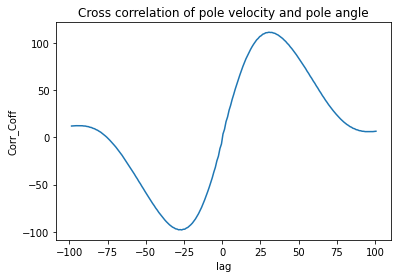

In [30]:

x=Dataset[:,1]
y=Dataset[:,2]

a=np.corrcoef(x,y)
b=np.correlate(x,y, 'same')
t=np.arange(1,len(b)+1)-len(b)/2
l=int((len(b)+1)/2)
plt.title("Cross correlation of pole velocity and pole angle")
plt.plot(t[l-100:l+100], b[l-100:l+100])
plt.ylabel('Corr_Coff')  
plt.xlabel('lag')
plt.savefig('CrossCorr_Angle_Velocity.pdf')
print(a)